In [1]:
import pandas as pd
import numpy as np
import random, os, sys 
from groo.groo import get_root
import matplotlib.pyplot as plt
import seaborn as sns

os.path.join(get_root(".tasks_root"))

mdf = pd.read_csv(os.path.join(get_root(".tasks_root"), "contextual-inference", "data", "meta_data.csv"))
mdf
mdf = mdf.loc[mdf["StrictInclude"]==1, ]

## collect main data set 

In [2]:
maindf = pd.DataFrame()
for idx, row in mdf.iterrows():
    rdf = pd.DataFrame()


    for cidx, c in enumerate(["r3", "r"+str(row["main2"])]):
        data = pd.read_json(os.path.join(get_root(".tasks_root"), "contextual-inference", "data", row["SubID"]+"_"+c+"_main"+str(cidx+1)+"_"+str(row["schid"])+".json"))
        data["trial"] = data.index
        data["rating_rt"]  = data["t_response_made"] - data["t_slider_shown"]
        data["err"] = data["outcome"] - data["rating"]
        data["abserr"] = np.abs(data["outcome"] - data["rating"])
        data["cond"] = c
        data["cond_order"] = cidx+1
        data["running_err"] = data["err"].rolling(4).mean().abs()
        data["SubID"] = row["SubID"]

        data["choice_rt"] = data["t_ch_choice_made"] - data["t_ch_targets_shown"]
        data['correctch'] = data.apply(lambda row: 1 if row['t1_ev'] > row['t2_ev'] else 2, axis=1)
        data['accuracy'] = (data['correctch'] == data['choice']).astype(int)
    
        maindf = pd.concat([maindf, data])

### Get ratings

In [3]:
manrats = pd.DataFrame()
for idx, row in mdf.iterrows():
    for cidx, c in enumerate(["r3", "r"+str(row["main2"])]):
        if row["HasRatings"]==1:
            data = pd.read_json(os.path.join(get_root(".tasks_root"), "contextual-inference", "data", row["SubID"]+"_"+c+"_main"+str(cidx+1)+"_"+str(row["schid"])+"_ratings.json"))
            data["SubID"] = row["SubID"]
            data["cond"] = c 
            data["cond_order"] = cidx+1
            manrats = pd.concat([manrats, data])
manrats


,rated_relevant,no_rated_relevant,subID,condition,truly_relevant,SubID,cond,cond_order
0,"[3, 2, 1]",3,ggg2ggg3,main1,"[2, 3, 1]",ggg2ggg3,r3,1
0,"[2, 4]",2,ggg2ggg3,main2,"[2, 4]",ggg2ggg3,r2,2
0,"[1, 3, 2]",3,YNs2wZj3,main1,"[2, 3, 1]",YNs2wZj3,r3,1
0,"[4, 2, 1, 0]",4,YNs2wZj3,main2,"[2, 4]",YNs2wZj3,r2,2
0,"[1, 0]",2,mFs2tQj1,main1,"[0, 1, 3]",mFs2tQj1,r3,1
0,"[2, 3]",2,mFs2tQj1,main2,"[2, 3]",mFs2tQj1,r2,2
0,"[1, 4, 2, 5, 3]",5,ZYq2NKp2,main1,"[4, 2, 1]",ZYq2NKp2,r3,1
0,"[1, 4, 0, 2]",4,ZYq2NKp2,main2,"[4, 1]",ZYq2NKp2,r2,2
0,"[5, 3]",2,bLw2aNY4,main1,"[0, 1, 5]",bLw2aNY4,r3,1
0,"[0, 5]",2,bLw2aNY4,main2,"[5, 0]",bLw2aNY4,r2,2


## Accuracy over time

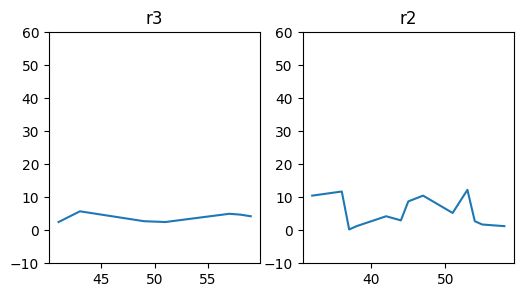

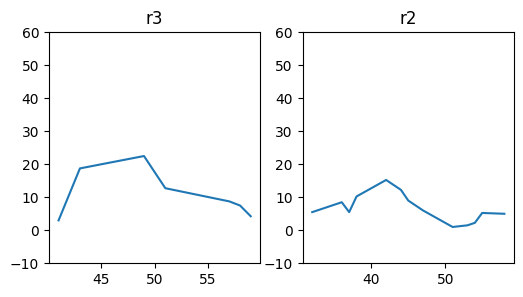

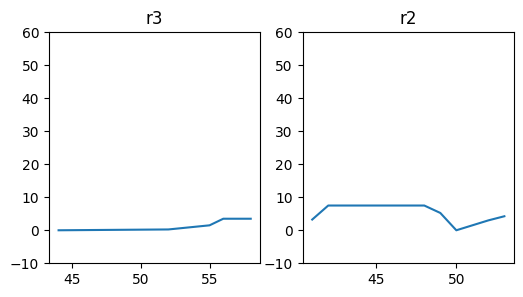

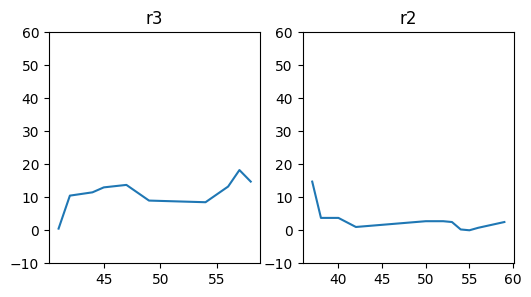

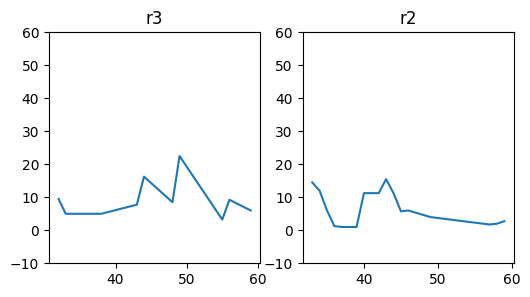

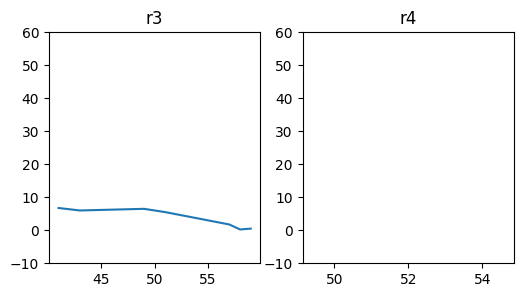

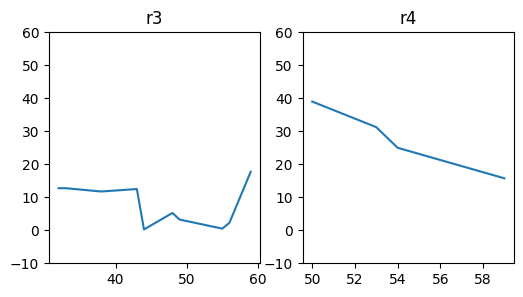

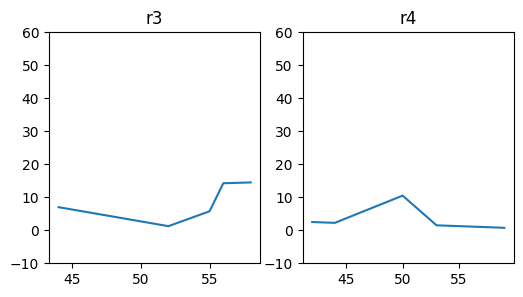

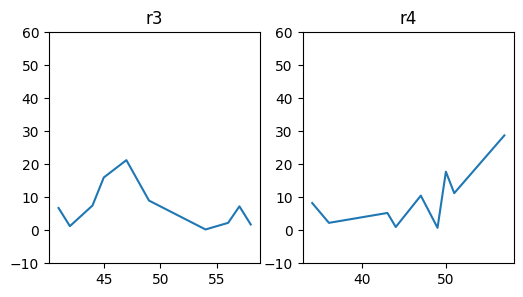

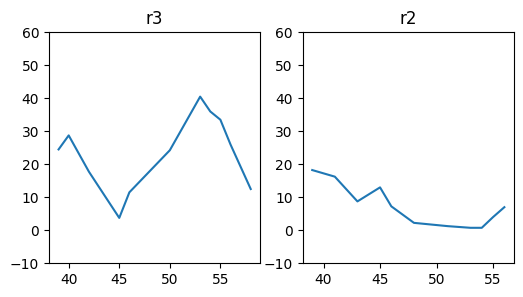

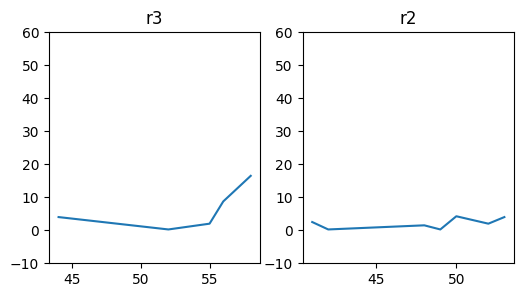

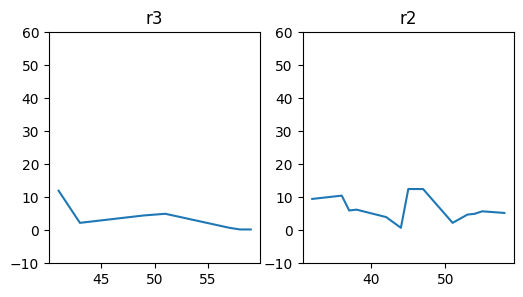

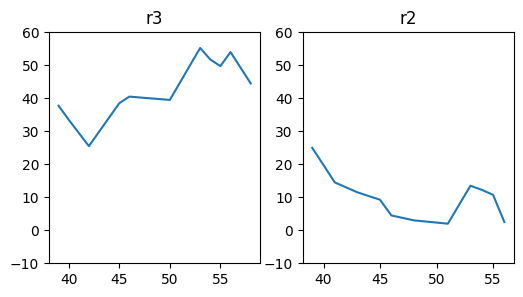

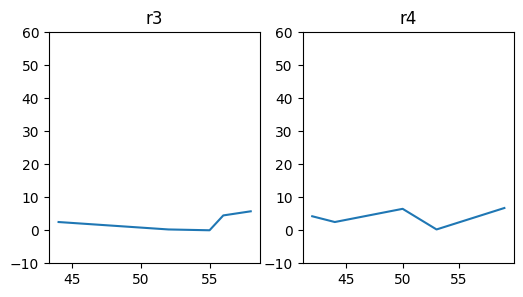

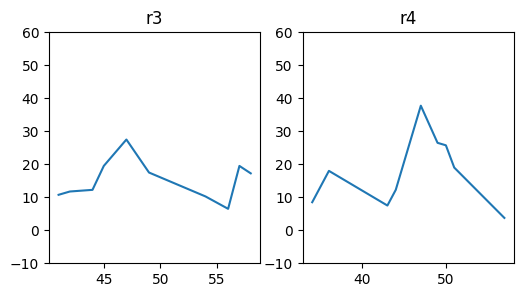

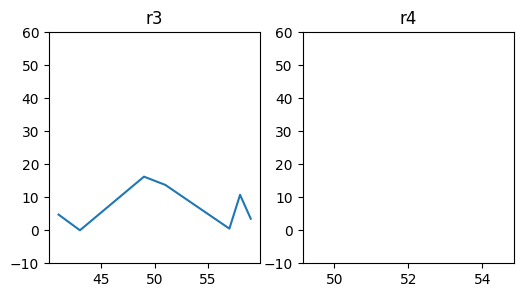

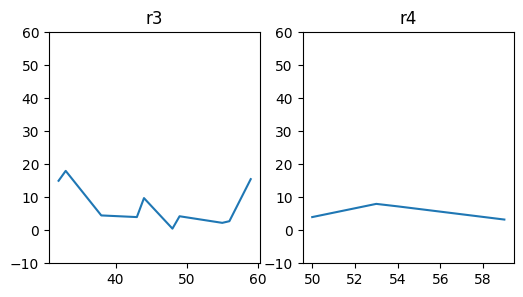

In [4]:
accdf = pd.DataFrame()
for idx, row in mdf.iterrows():
    rdf = pd.DataFrame()

    f, ax = plt.subplots(1,2,figsize=(6,3))

    for cidx, c in enumerate(["r3", "r"+str(row["main2"])]):
        data = pd.read_json(os.path.join(get_root(".tasks_root"), "contextual-inference", "data", row["SubID"]+"_"+c+"_main"+str(cidx+1)+"_"+str(row["schid"])+".json"))
        data["trial"] = data.index
        rat = data.loc[(data["require_rating"]==1) & (data["decision"]==0),["target", "trial", "outcome", "t1_ev", "t2_ev", "rating", "t_slider_shown", "t_response_made"]]
        rat["RT"]  = rat["t_response_made"] - rat["t_slider_shown"]
        rat["err"] = rat["outcome"] - rat["rating"]
        rat["abserr"] = np.abs(rat["outcome"] - rat["rating"])
        rat["cond"] = c
        rat["cond_order"] = cidx+1
        rat["running_err"] = rat["err"].rolling(4).mean().abs()
        rat["SubID"] = row["SubID"]
        
    
        rdf = pd.concat([rdf, rat])

        ## plot 
        ax[cidx].plot(rat["trial"], rat["running_err"])
        ax[cidx].set_title("Running (smoothed) accuracy "+ row["SubID"])
        ax[cidx].set_ylim(-10, 60)
        ax[cidx].set_title(c)
    
    
    rdf= rdf.reset_index()
    #rdf["trial"] = rdf.index
    accdf = pd.concat([accdf, rdf])

    


        
accdf = accdf.reset_index()

In [5]:
accsum = accdf.groupby(by=["SubID", "cond"])["err", "abserr", "RT"].mean().reset_index()
accsum

/tmp/ipykernel_3637588/1813227569.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  accsum = accdf.groupby(by=["SubID", "cond"])["err", "abserr", "RT"].mean().reset_index()


,SubID,cond,err,abserr,RT
0,LWe2hXz1,r2,-3.400000,8.200000,4491.570000
1,LWe2hXz1,r3,6.250000,16.750000,6794.362500
2,SKY2kJb0,r2,-6.142857,13.857143,3796.250000
3,SKY2kJb0,r3,-21.071429,28.785714,5253.050000
4,TXp4tLJ3,r3,3.200000,4.600000,5498.420000
5,TXp4tLJ3,r4,11.500000,12.000000,3642.650000
6,TpL4mXY2,r3,-6.461538,15.076923,10906.307692
7,TpL4mXY2,r4,-8.833333,25.500000,4566.966667
8,YKJ4wLr1,r3,3.750000,23.000000,5517.250000
9,YKJ4wLr1,r4,-1.625000,19.875000,5371.375000


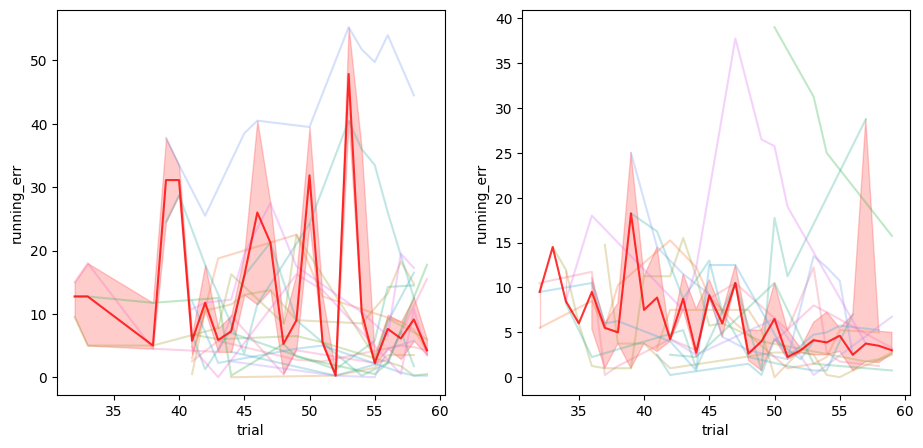

In [6]:
f, ax = plt.subplots(1,2,figsize=(11,5))

for cidx in range(1,3):

    sns.lineplot(data = accdf.loc[accdf["cond_order"]==cidx,], x="trial", y="running_err",hue="SubID", alpha=0.3, color="gray", estimator="median", errorbar=('ci', 68), ax=ax[cidx-1])
    sns.lineplot(data = accdf.loc[accdf["cond_order"]==cidx,], x="trial", y="running_err",alpha=0.8, color="red", estimator="median", errorbar=('ci', 68), ax=ax[cidx-1])
    ax[cidx-1].get_legend().remove()


### Binned running error

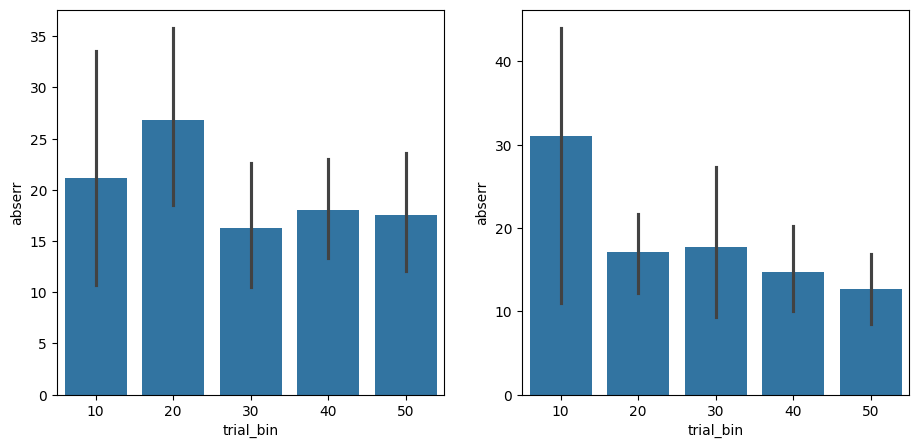

In [7]:
accdf["trial_bin"] = (accdf["trial"] // 10) * 10

f, ax = plt.subplots(1,2,figsize=(11,5))

for cidx in range(1,3):

    # Aggregate RT and running_err by SubID and trial_bin
    agg_df = accdf.loc[accdf["cond_order"]==cidx,].groupby(["SubID", "trial_bin"]).agg(
        {"RT": "mean", "abserr": "mean"}
    ).reset_index()

    sns.barplot(agg_df, x="trial_bin", y="abserr", ax=ax[cidx-1])



### Binned RTs

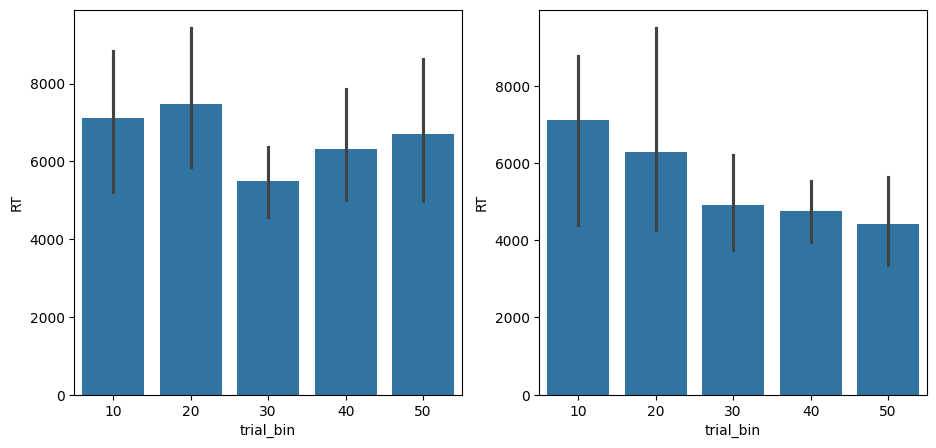

In [8]:
accdf["trial_bin"] = (accdf["trial"] // 10) * 10

f, ax = plt.subplots(1,2,figsize=(11,5))

for cidx in range(1,3):

    # Aggregate RT and running_err by SubID and trial_bin
    agg_df = accdf.loc[accdf["cond_order"]==cidx,].groupby(["SubID", "trial_bin"]).agg(
        {"RT": "mean", "running_err": "mean"}
    ).reset_index()

    sns.barplot(agg_df, x="trial_bin", y="RT", ax=ax[cidx-1])

In [9]:
#pd.DataFrame({"SubID":row["SubID"], "cond": c, "choice_acc": chd['accuracy'].mean().round(2)}, index=[0])

## Choices 

In [10]:
chdf = pd.DataFrame()
for idx, row in mdf.iterrows():
    rdf = pd.DataFrame()

    #f, ax = plt.subplots(1,2,figsize=(6,3))

    for cidx, c in enumerate(["r3", "r"+str(row["main2"])]):
        data = pd.read_json(os.path.join(get_root(".tasks_root"), "contextual-inference", "data", row["SubID"]+"_"+c+"_main"+str(cidx+1)+"_"+str(row["schid"])+".json"))
        data["trial"] = data.index
        chd = data.loc[(data["decision"]==1) & (data["decision"]==1),["target", "trial", "outcome", "t1_ev", "t2_ev", "choice", "t_ch_targets_shown", "t_ch_choice_made"]]
        chd["rt"] = chd["t_ch_choice_made"] - chd["t_ch_targets_shown"]
        chd['correctch'] = chd.apply(lambda row: 1 if row['t1_ev'] > row['t2_ev'] else 2, axis=1)
        chd['accuracy'] = (chd['correctch'] == chd['choice']).astype(int)
        chd["cond"] = c
        chd["cond_order"] = cidx+1

        acc_flt = chd.loc[chd["trial"]>30, "accuracy"].astype(int).mean()

        chdf = pd.concat([chdf, pd.DataFrame({"SubID":row["SubID"], "cond": c, "choice_acc": chd['accuracy'].mean().round(2), "choice_acc_t20":acc_flt}, index=[0])])
        print(row["SubID"] + " " + c + " " + str(chd['accuracy'].mean().round(2)))
        

ggg2ggg3 r3 0.94
ggg2ggg3 r2 0.75
YNs2wZj3 r3 0.59
YNs2wZj3 r2 0.92
mFs2tQj1 r3 0.89
mFs2tQj1 r2 0.93
ZYq2NKp2 r3 0.89
ZYq2NKp2 r2 1.0
bLw2aNY4 r3 0.75
bLw2aNY4 r2 0.57
TXp4tLJ3 r3 0.88
TXp4tLJ3 r4 0.82
aNY4dCQ4 r3 0.5
aNY4dCQ4 r4 0.6
YKJ4wLr1 r3 0.42
YKJ4wLr1 r4 0.53
TpL4mXY2 r3 0.78
TpL4mXY2 r4 0.61
SKY2kJb0 r3 0.44
SKY2kJb0 r2 0.46
LWe2hXz1 r3 0.47
LWe2hXz1 r2 0.33
ZhB2XOk3 r3 0.59
ZhB2XOk3 r2 0.58
cPQ2Iow0 r3 0.56
cPQ2Iow0 r2 0.62
ywA4OSQ1 r3 0.84
ywA4OSQ1 r4 0.68
fCc4qic2 r3 0.72
fCc4qic2 r4 0.56
rar4Nob3 r3 0.59
rar4Nob3 r4 0.64
zHV4YCg4 r3 0.4
zHV4YCg4 r4 0.35


In [11]:
chd

,target,trial,outcome,t1_ev,t2_ev,choice,t_ch_targets_shown,t_ch_choice_made,rt,correctch,accuracy,cond,cond_order
25,1.0,25,6.0,5.0,-15.0,2.0,2300444.5,2302539.0,2094.5,1,0,r4,2
26,1.0,26,28.0,25.0,-55.0,2.0,2310238.0,2313374.2,3136.2,1,0,r4,2
27,2.0,27,-31.0,30.0,-30.0,2.0,2321081.8,2322788.8,1707.0,1,0,r4,2
30,1.0,30,-24.0,-25.0,15.0,1.0,2347909.4,2351767.3,3857.9,2,0,r4,2
35,1.0,35,26.0,25.0,-15.0,1.0,2394305.7,2396695.8,2390.1,1,1,r4,2
37,2.0,37,-20.0,25.0,-15.0,1.0,2413107.7,2414774.8,1667.1,1,1,r4,2
38,2.0,38,17.0,-25.0,15.0,1.0,2422450.6,2426982.2,4531.6,2,0,r4,2
39,1.0,39,-26.0,-25.0,15.0,2.0,2434679.3,2436691.5,2012.2,2,1,r4,2
40,2.0,40,13.0,-25.0,15.0,1.0,2444389.0,2447738.8,3349.8,2,0,r4,2
41,2.0,41,-40.0,20.0,-40.0,2.0,2455433.8,2458516.3,3082.5,1,0,r4,2


### Survey data

In [12]:
sdf = pd.read_csv(os.path.join(get_root(".tasks_root"), "contextual-inference", "data", "survey_data.csv"))
sdf = sdf.loc[sdf["lastpage"]==3,]
sdf

,id,submitdate,lastpage,startlanguage,seed,startdate,datestamp,refurl,id.1,q1,...,idTime,groupTime104426,q1Time,q2Time,q3Time,q4Time,q5Time,groupTime104414,STAITTime,staitestTime
0,3,2025-02-03 10:38:42,3,en,67674040,2025-02-03 10:38:20,2025-02-03 10:38:42,NaN,testt2,NaN,...,NaN,6.01,NaN,NaN,NaN,NaN,NaN,13.88,NaN,NaN
1,9,2025-02-03 15:16:06,3,en,1815444122,2025-02-03 15:12:00,2025-02-03 15:16:06,NaN,cLr2qXf2,Probably contextual inference as it says so in...,...,NaN,145.84,NaN,NaN,NaN,NaN,NaN,95.32,NaN,NaN
2,10,2025-02-03 17:09:26,3,en,1130921787,2025-02-03 17:03:26,2025-02-03 17:09:26,NaN,vMe2FJk1,The purpose was to identify ingredients that w...,...,NaN,206.91,NaN,NaN,NaN,NaN,NaN,147.51,NaN,NaN
3,11,2025-02-04 11:33:24,3,en,1935335736,2025-02-04 11:26:27,2025-02-04 11:33:24,NaN,XjK2mTp0,I had to figure out which element had the best...,...,NaN,305.10,NaN,NaN,NaN,NaN,NaN,108.23,NaN,NaN
4,16,2025-02-05 09:59:09,3,en,2122035954,2025-02-05 09:52:17,2025-02-05 09:59:09,NaN,TXp4tLJ3,Finding the ingredients that interact with the...,...,NaN,280.64,NaN,NaN,NaN,NaN,NaN,123.47,NaN,NaN
5,20,2025-02-05 15:55:40,3,en,1806633693,2025-02-05 15:43:31,2025-02-05 15:55:40,NaN,aXv2dCm0,I can't .. :( I had an idea that is has someth...,...,NaN,330.76,NaN,NaN,NaN,NaN,NaN,268.37,NaN,NaN
6,21,2025-02-05 16:23:31,3,en,1414691283,2025-02-05 16:12:54,2025-02-05 16:23:31,NaN,mFs2tQj1,Consider the association between a particle co...,...,NaN,501.01,NaN,NaN,NaN,NaN,NaN,130.41,NaN,NaN
7,22,2025-02-05 21:50:13,3,en,1169641117,2025-02-05 21:44:31,2025-02-05 21:50:13,NaN,TpL4mXY2,I misunderstood I think - I thought I had to f...,...,NaN,261.34,NaN,NaN,NaN,NaN,NaN,71.80,NaN,NaN
8,23,2025-02-06 12:06:36,3,en,1302876545,2025-02-06 11:54:37,2025-02-06 12:06:36,NaN,YNs2wZj3,I had to find the right ingredients out of the...,...,NaN,557.41,NaN,NaN,NaN,NaN,NaN,155.49,NaN,NaN
9,24,2025-02-06 12:37:21,3,en,1391565966,2025-02-06 12:34:14,2025-02-06 12:37:21,https://www.google.com/,ggg2ggg3,It was good.,...,NaN,88.48,NaN,NaN,NaN,NaN,NaN,96.56,NaN,NaN


In [13]:



cols = ["STAIT[stait"+str(x)+"]" for x in [2,4,5,8,9,11,12,15,17,18,20]]
for c in cols:
    sdf[c] = sdf[c].replace({"Almost never": 1, "Sometimes": 2, "Often": 3, "Almost always":4} )

cols2 = ["STAIT[stait"+str(x)+"]" for x in [1,3,6,7,10,13,14,16,19]]
allcols = ["STAIT[stait"+str(x)+"]" for x in range(1,21)]
for c in cols2:
    sdf[c] = sdf[c].replace({"Almost never": 4, "Sometimes": 3, "Often": 2, "Almost always": 1} ) 

stait = sdf.loc[:, ["id.1"]+allcols]
stait = stait.rename(columns={"id.1": "SubID"})
stait = stait.set_index("SubID")
stait["ta"] = stait.sum(axis=1)
stait = stait.reset_index()
stait = stait[["SubID", "ta"]]



In [14]:
mdf
mdf["m2_cond"] = "r"+mdf["main2"].astype(str)
mdf["m1_cond"] = "r3"
mdf

,Done,StrictInclude,HasRatings,Est_ctxt_main1,Est_ctxt_main2,SubID,main2,schid,m2_cond,m1_cond
0,1,1,1,3.0,2.0,ggg2ggg3,2,3,r2,r3
4,1,1,1,2.0,4.0,YNs2wZj3,2,3,r2,r3
6,1,1,1,2.0,2.0,mFs2tQj1,2,1,r2,r3
7,1,1,1,6.0,4.0,ZYq2NKp2,2,2,r2,r3
8,1,1,1,2.0,2.0,bLw2aNY4,2,4,r2,r3
9,1,1,1,3.0,3.0,TXp4tLJ3,4,3,r4,r3
10,1,1,1,3.0,3.0,aNY4dCQ4,4,4,r4,r3
11,1,1,1,1.0,3.0,YKJ4wLr1,4,1,r4,r3
12,1,1,0,3.0,4.0,TpL4mXY2,4,2,r4,r3
13,1,1,1,3.0,2.0,SKY2kJb0,2,0,r2,r3


In [15]:
mdf2 = mdf[["SubID", "Est_ctxt_main1", "Est_ctxt_main2"]].melt(var_name="tc", value_name="est_ctx", id_vars="SubID") #.rename(columns={"Est_ctxt_main1": "m1"})
mdf2["tc"] = mdf2["tc"].replace({ "Est_ctxt_main1": "m1" ,"Est_ctxt_main2": "m2"})

mdf3 = mdf[["SubID", "m1_cond", "m2_cond"]].melt(var_name="tc", value_name="cond", id_vars="SubID") #.rename(columns={"Est_ctxt_main1": "r"})
mdf3["tc"] = mdf3["tc"].replace({ "m1_cond": "m1" ,"m2_cond": "m2"})

# form basic data per sub
fidf = pd.merge(mdf2, mdf3, on=["SubID", "tc"], how="left")

# merge accuracies
fidf = pd.merge(fidf, accsum, on=["SubID", "cond"], how="left")

# merge choices
fidf = pd.merge(fidf, chdf, on=["SubID", "cond"], how="left")

# merge ratings made in task 
fidf = pd.merge(fidf, manrats, on=["SubID", "cond"], how="left")

# merge anxiety 
fidf = pd.merge(fidf, stait, on=["SubID"], how="left")

# extract true number of contexts
fidf['true_ctx'] = fidf['cond'].str.extract('(\d+)').astype(int)
fidf["ctxt_diff"] = fidf["est_ctx"] - fidf["true_ctx"]
fidf["rated_diff"] = fidf["no_rated_relevant"] - fidf["true_ctx"]

print(fidf["SubID"].unique().shape)
fidf


(17,)


,SubID,tc,est_ctx,cond,err,abserr,RT,choice_acc,choice_acc_t20,rated_relevant,no_rated_relevant,subID,condition,truly_relevant,cond_order,ta,true_ctx,ctxt_diff,rated_diff
0,ggg2ggg3,m1,3.0,r3,0.900000,7.900000,4628.900000,0.94,0.923077,"[3, 2, 1]",3.0,ggg2ggg3,main1,"[2, 3, 1]",1.0,49.0,3,0.0,0.0
1,YNs2wZj3,m1,2.0,r3,-5.200000,21.000000,6592.600000,0.59,0.615385,"[1, 3, 2]",3.0,YNs2wZj3,main1,"[2, 3, 1]",1.0,41.0,3,-1.0,0.0
2,mFs2tQj1,m1,2.0,r3,1.750000,6.000000,7603.762500,0.89,0.866667,"[1, 0]",2.0,mFs2tQj1,main1,"[0, 1, 3]",1.0,44.0,3,-1.0,-1.0
3,ZYq2NKp2,m1,6.0,r3,1.461538,15.615385,9843.692308,0.89,1.000000,"[1, 4, 2, 5, 3]",5.0,ZYq2NKp2,main1,"[4, 2, 1]",1.0,38.0,3,3.0,2.0
4,bLw2aNY4,m1,2.0,r3,-1.615385,26.076923,5628.500000,0.75,0.823529,"[5, 3]",2.0,bLw2aNY4,main1,"[0, 1, 5]",1.0,44.0,3,-1.0,-1.0
5,TXp4tLJ3,m1,3.0,r3,3.200000,4.600000,5498.420000,0.88,0.923077,"[1, 2, 3]",3.0,TXp4tLJ3,main1,"[2, 3, 1]",1.0,40.0,3,0.0,0.0
6,aNY4dCQ4,m1,3.0,r3,0.384615,18.692308,3724.838462,0.50,0.470588,"[1, 2, 5, 3]",4.0,aNY4dCQ4,main1,"[0, 1, 5]",1.0,25.0,3,0.0,1.0
7,YKJ4wLr1,m1,1.0,r3,3.750000,23.000000,5517.250000,0.42,0.400000,"[5, 1, 4]",3.0,YKJ4wLr1,main1,"[0, 1, 3]",1.0,41.0,3,-2.0,0.0
8,TpL4mXY2,m1,3.0,r3,-6.461538,15.076923,10906.307692,0.78,0.769231,NaN,NaN,NaN,NaN,NaN,NaN,22.0,3,0.0,NaN
9,SKY2kJb0,m1,3.0,r3,-21.071429,28.785714,5253.050000,0.44,0.333333,"[5, 4, 3]",3.0,SKY2kJb0,main1,"[4, 0, 1]",1.0,NaN,3,0.0,0.0


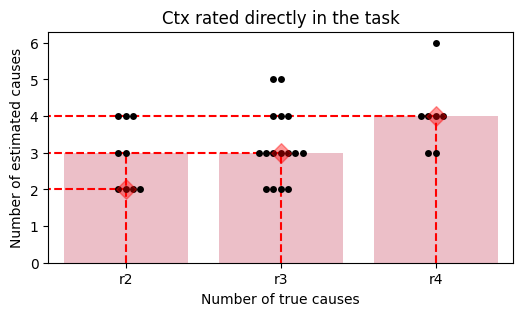

cond
r2    0.888889
r3    0.187500
r4    0.000000
Name: rated_diff, dtype: float64

In [ ]:
f, ax = plt.subplots(1,1,figsize=(6,3))
#sns.barplot(fidf, x="cond", y="est_ctx", ax=ax)
sns.barplot(fidf, x="cond", y="no_rated_relevant", color="crimson", estimator="median", errorbar=None, alpha = 0.3, ax=ax, order=["r2", "r3", "r4"] )
sns.swarmplot(fidf, x="cond", y="no_rated_relevant", color="black", ax=ax)
ax.set_xlabel("Number of true causes")
ax.set_ylabel("Number of estimated causes")
fidf[["true_ctx", "no_rated_relevant"]].corr(method="spearman")
modes = (fidf
         .groupby("cond")["no_rated_relevant"]
         .apply(lambda x: x.mode().iloc[0])  # get the first mode if multiple
        )

# 2. Plot the mode for each condition as a red diamond
for i, cond in enumerate(["r2", "r3", "r4"]):
    ax.scatter(
        i, 
        modes[cond], 
        color='red', 
        alpha=0.4,
        marker='D',  # Diamond marker
        s=100,       # Marker size (adjust to taste)
        zorder=10    # Ensure it’s on top of other plots
    )
# 3. Add horizontal dashed red lines at y=2,3,4 from x=0 to x=y
for yval in [2, 3, 4]:
    ax.hlines(y=yval, xmin=-1, xmax=yval-2, color='red', linestyle='--')

# 4. Add vertical dashed red lines at each category's median
for i, cond in enumerate(["r2", "r3", "r4"]):
    median_val = fidf.loc[fidf['cond'] == cond, 'no_rated_relevant'].median()
    ax.vlines(x=i, ymin=0, ymax=median_val, color='red', linestyle='--')
plt.xlim([-0.5,2.5])
plt.title("Ctx rated directly in the task")
plt.show()



In [24]:
fidf["rated_diff"].mean()


0.34375

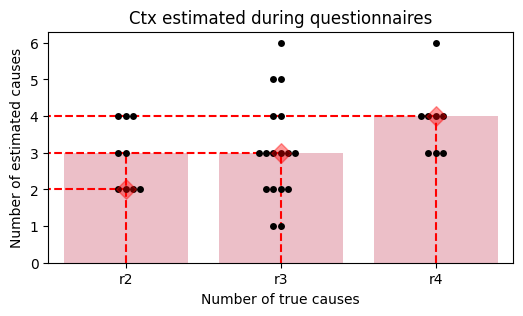

In [ ]:
f, ax = plt.subplots(1,1,figsize=(6,3))
#sns.barplot(fidf, x="cond", y="est_ctx", ax=ax)
sns.barplot(fidf, x="cond", y="est_ctx", color="crimson", estimator="median", errorbar=None, alpha = 0.3, ax=ax, order=["r2", "r3", "r4"] )
sns.swarmplot(fidf, x="cond", y="est_ctx", color="black", ax=ax)
ax.set_xlabel("Number of true causes")
ax.set_ylabel("Number of estimated causes")
fidf[["true_ctx", "est_ctx"]].corr(method="spearman")
modes = (fidf
         .groupby("cond")["est_ctx"]
         .apply(lambda x: x.mode().iloc[0])  # get the first mode if multiple
        )

# 2. Plot the mode for each condition as a red diamond
for i, cond in enumerate(["r2", "r3", "r4"]):
    ax.scatter(
        i, 
        modes[cond], 
        color='red', 
        alpha=0.4,
        marker='D',  # Diamond marker
        s=100,       # Marker size (adjust to taste)
        zorder=10    # Ensure it’s on top of other plots
    )
# 3. Add horizontal dashed red lines at y=2,3,4 from x=0 to x=y
for yval in [2, 3, 4]:
    ax.hlines(y=yval, xmin=-1, xmax=yval-2, color='red', linestyle='--')

# 4. Add vertical dashed red lines at each category's median
for i, cond in enumerate(["r2", "r3", "r4"]):
    median_val = fidf.loc[fidf['cond'] == cond, 'est_ctx'].median()
    ax.vlines(x=i, ymin=0, ymax=median_val, color='red', linestyle='--')
plt.xlim([-0.5,2.5])
plt.title("Ctx estimated during questionnaires")
plt.show()

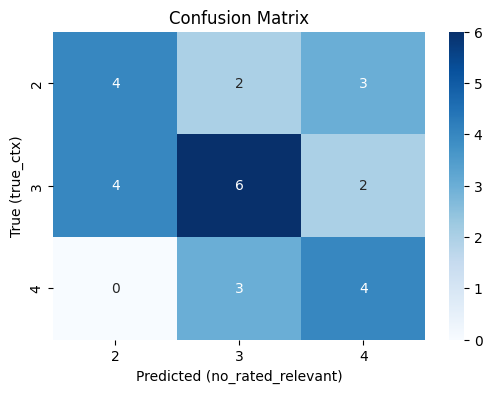

In [ ]:
conf_matrix = pd.crosstab(fidf['true_ctx'], fidf['est_ctx'])

# Step 2: Reindex the rows and columns so that
#         the matrix order is [2, 3, 4] for both axis.
row_order = [2, 3, 4]
col_order = [2, 3, 4]
conf_matrix = conf_matrix.reindex(index=row_order, columns=col_order, fill_value=0)

# Step 3: Plot the confusion matrix as a heatmap.
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g')

# Step 4: Label the plot.
plt.title('Confusion Matrix')
plt.xlabel('Predicted (no_rated_relevant)')
plt.ylabel('True (true_ctx)')
plt.show()

<Axes: xlabel='cond', ylabel='no_rated_relevant'>

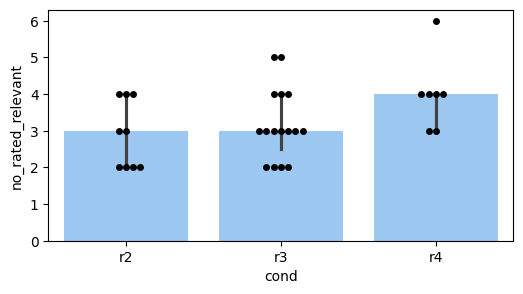

In [ ]:
f, ax = plt.subplots(1,1,figsize=(6,3))
#sns.barplot(fidf, x="cond", y="est_ctx", ax=ax)
sns.barplot(fidf, x="cond", y="no_rated_relevant", color="dodgerblue", estimator="median", alpha = 0.5, ax=ax, order=["r2", "r3", "r4"] )
sns.swarmplot(fidf, x="cond", y="no_rated_relevant", color="black", ax=ax)

Text(0.2222222222222232, 0.5, 'Average accuracy')

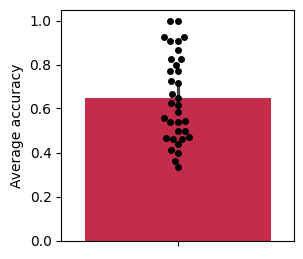

In [ ]:
f, ax = plt.subplots(1,1,figsize=(3,3))

acc = fidf.loc[:,["SubID","choice_acc_t20"]].groupby("SubID")["choice_acc_t20"].mean().reset_index()
#sns.barplot(fidf, x="cond", y="est_ctx", ax=ax)
#sns.barplot(fidf,  y="choice_acc", color="crimson", estimator="mean", alpha = 1, ax=ax, order=["r2", "r3", "r4"] )
sns.barplot(fidf,  y="choice_acc_t20", color="crimson", estimator="mean", alpha = 1, ax=ax )
sns.swarmplot(fidf,  y="choice_acc_t20", color="black", ax=ax)

ax.set_xlabel("")
ax.set_ylabel("Average accuracy")


In [ ]:
fidf.loc[fidf["tc"]=="m1",].corr(method="pearson")

/tmp/ipykernel_229783/1306148189.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  fidf.loc[fidf["tc"]=="m1",].corr(method="pearson")


,est_ctx,err,abserr,RT,choice_acc,choice_acc_t20,no_rated_relevant,cond_order,ta,true_ctx,ctxt_diff,rated_diff
est_ctx,1.000000,0.338935,-0.451864,0.375157,0.384638,0.292137,0.842823,NaN,-0.186304,NaN,1.000000,0.842823
err,0.338935,1.000000,-0.753954,0.132022,0.238031,0.204803,0.348926,NaN,-0.128696,NaN,0.338935,0.348926
abserr,-0.451864,-0.753954,1.000000,-0.129847,-0.660334,-0.544304,-0.424035,NaN,-0.019152,NaN,-0.451864,-0.424035
RT,0.375157,0.132022,-0.129847,1.000000,0.292471,0.348415,0.156373,NaN,-0.300342,NaN,0.375157,0.156373
choice_acc,0.384638,0.238031,-0.660334,0.292471,1.000000,0.959401,0.207336,NaN,0.347769,NaN,0.384638,0.207336
choice_acc_t20,0.292137,0.204803,-0.544304,0.348415,0.959401,1.000000,0.114286,NaN,0.327877,NaN,0.292137,0.114286
no_rated_relevant,0.842823,0.348926,-0.424035,0.156373,0.207336,0.114286,1.000000,NaN,-0.217530,NaN,0.842823,1.000000
cond_order,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ta,-0.186304,-0.128696,-0.019152,-0.300342,0.347769,0.327877,-0.217530,NaN,1.000000,NaN,-0.186304,-0.217530
true_ctx,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<Axes: xlabel='ta', ylabel='err'>

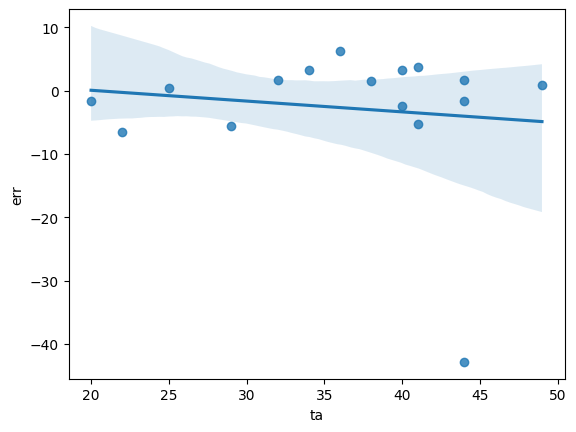

In [ ]:
sns.regplot(data=fidf.loc[fidf["tc"]=="m1",], x="ta", y="err")

<Axes: xlabel='ta', ylabel='ctxt_diff'>

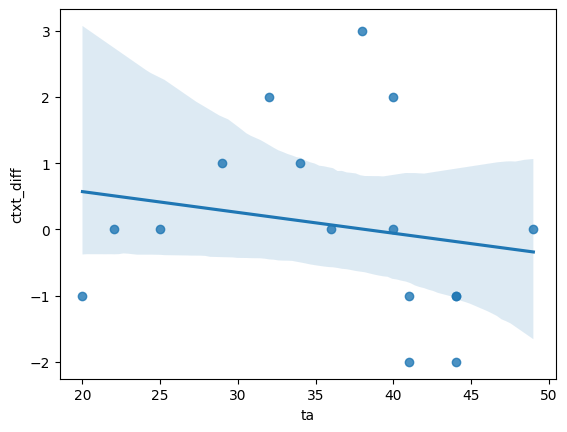

In [ ]:
sns.regplot(data=fidf.loc[fidf["tc"]=="m1",], x="ta", y="ctxt_diff")

<Axes: xlabel='ta', ylabel='rated_diff'>

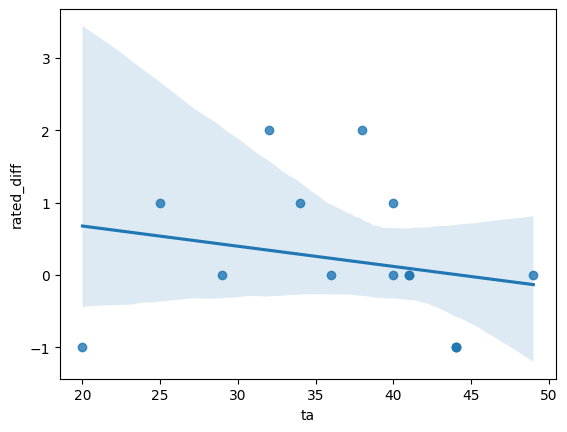

In [ ]:
sns.regplot(data=fidf.loc[fidf["tc"]=="m1",], x="ta", y="rated_diff")

<Axes: xlabel='ta', ylabel='choice_acc_t20'>

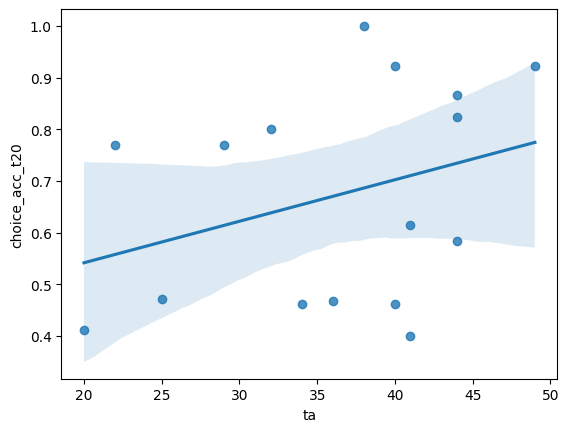

In [ ]:
sns.regplot(data=fidf.loc[fidf["tc"]=="m1",], x="ta", y="choice_acc_t20")

In [ ]:
fidf.loc[fidf["tc"]=="m2",].corr()

/tmp/ipykernel_229783/1321862680.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  fidf.loc[fidf["tc"]=="m2",].corr()


,est_ctx,err,abserr,RT,choice_acc,choice_acc_t20,no_rated_relevant,cond_order,ta,true_ctx,ctxt_diff,rated_diff
est_ctx,1.000000,0.335847,0.304883,0.346392,-0.113204,-0.115120,0.973395,NaN,-0.564222,0.479905,0.529423,0.568750
err,0.335847,1.000000,-0.257143,0.293961,0.207231,0.194077,0.200156,NaN,0.183083,0.081568,0.254784,0.080984
abserr,0.304883,-0.257143,1.000000,-0.256156,-0.280369,-0.328249,0.411000,NaN,-0.570565,0.623823,-0.300332,-0.149925
RT,0.346392,0.293961,-0.256156,1.000000,0.396637,0.390548,0.290477,NaN,0.259539,-0.026233,0.369503,0.322847
choice_acc,-0.113204,0.207231,-0.280369,0.396637,1.000000,0.969374,-0.120856,NaN,0.463934,-0.231487,0.111378,0.098550
choice_acc_t20,-0.115120,0.194077,-0.328249,0.390548,0.969374,1.000000,-0.101644,NaN,0.421928,-0.238882,0.116626,0.098672
no_rated_relevant,0.973395,0.200156,0.411000,0.290477,-0.120856,-0.101644,1.000000,NaN,-0.664697,0.523322,0.469358,0.534052
cond_order,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ta,-0.564222,0.183083,-0.570565,0.259539,0.463934,0.421928,-0.664697,NaN,1.000000,-0.613795,0.047861,-0.102917
true_ctx,0.479905,0.081568,0.623823,-0.026233,-0.231487,-0.238882,0.523322,NaN,-0.613795,1.000000,-0.490209,-0.440959


<Axes: xlabel='ta', ylabel='ctxt_diff'>

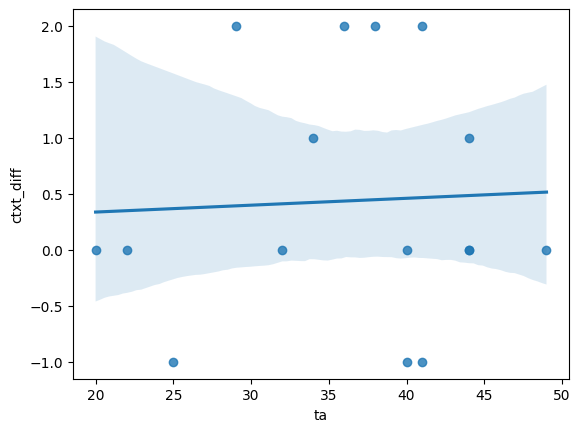

In [ ]:
sns.regplot(data=fidf.loc[fidf["tc"]=="m2",], x="ta", y="ctxt_diff")

<Axes: xlabel='ta', ylabel='abserr'>

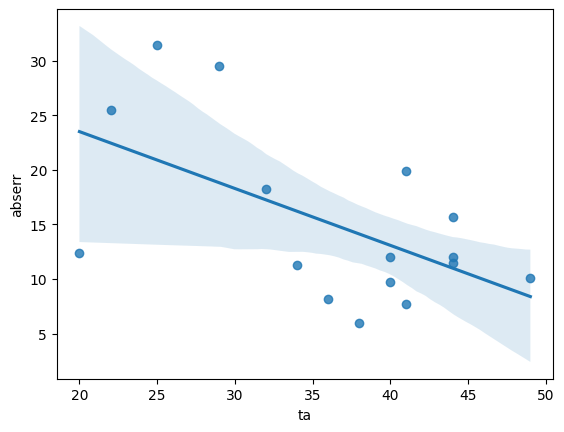

In [ ]:
sns.regplot(data=fidf.loc[fidf["tc"]=="m2",], x="ta", y="abserr")

<Axes: xlabel='ta', ylabel='choice_acc'>

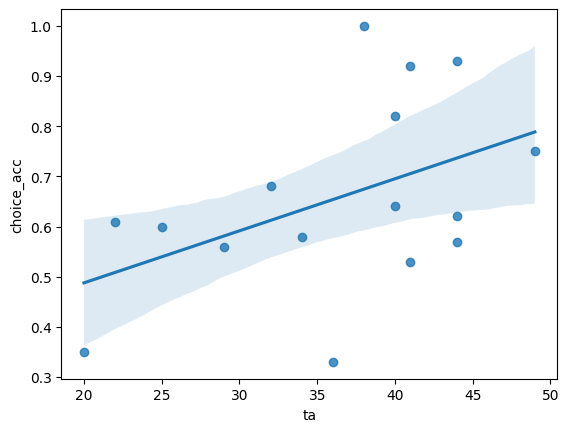

In [ ]:
sns.regplot(data=fidf.loc[fidf["tc"]=="m2",], x="ta", y="choice_acc")

<Axes: xlabel='ta', ylabel='rated_diff'>

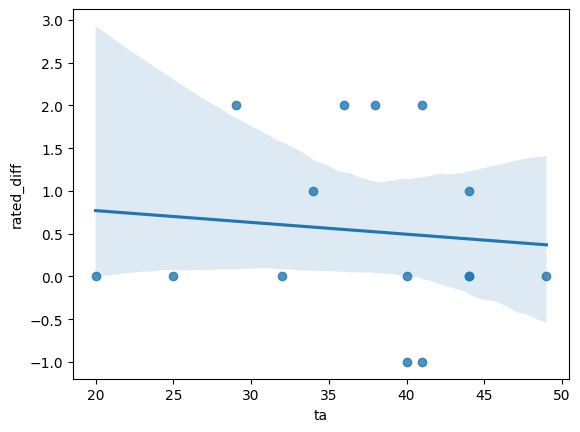

In [ ]:
sns.regplot(data=fidf.loc[fidf["tc"]=="m2",], x="ta", y="rated_diff")

### Get ratings from the rating at the end of each block 

## Do ratings reflect the underlying value? 

This is helpful to determine if people use the task 

In [ ]:
import patsy
import statsmodels.api as sm
def regress_ratings(df):
    df = df.loc[(df["require_rating"]==1) & (df["decision"]==0),]
    formula = "rating ~ outcome_rel_stim1 + outcome_rel_stim2"
    y, X = patsy.dmatrices(formula, df, return_type='dataframe')
    model = sm.OLS(y, X).fit()
    results_df = pd.DataFrame({
        "Feature": model.params.index,
        "Coefficient": model.params.values,
        "Lower 95% CI": model.conf_int()[0].values,
        "Upper 95% CI": model.conf_int()[1].values,
        "P-value": model.pvalues.values
    })

    return(results_df)
maindf.groupby(by=["SubID", "rel_cond"]).apply(regress_ratings)

Feature  Coefficient  Lower 95% CI  \
SubID    rel_cond                                                   
LWe2hXz1 rel2     0          Intercept    -1.343750     -6.264387   
                  1  outcome_rel_stim1    -0.325000     -0.829018   
                  2  outcome_rel_stim2    -0.643750     -2.858709   
         rel3     0          Intercept    -1.883490    -21.047602   
                  1  outcome_rel_stim1     0.030512     -2.856537   
...                                ...          ...           ...   
zHV4YCg4 rel3     1  outcome_rel_stim1    -0.845565     -1.920894   
                  2  outcome_rel_stim2    -0.349528     -0.940066   
         rel4     0          Intercept    -9.524007    -32.906510   
                  1  outcome_rel_stim1     1.601223     -0.261374   
                  2  outcome_rel_stim2     0.356990     -0.565028   

                     Upper 95% CI   P-value  
SubID    rel_cond                            
LWe2hXz1 rel2     0      3.576887  0.539030  
                  1      0.179018  0.171148  
                  2      1.571209  0.514044  
         rel3     0     17.280622  0.810602  
                  1      2.917561  0.979377  
...                           ...       ...  
zHV4YCg4 rel3     1      0.229765  0.110314  
                  2      0.241011  0.216642  
         rel4     0     13.858497  0.321315  
                  1      3.463820  0.075427  
                  2      1.279009  0.342899  

[102 rows x 5 columns]